In [1]:
import matplotlib.pyplot as plt
import csv
import numpy as np
import pandas as pd
import re
import json
import os

In [2]:
root_folder = "/home/lizhouyu/home/lizhouyu/zch_results"
stats_folders = [x for x in os.listdir(root_folder) if x.startswith("result_tbsize_10000") and "kuairand27k" in x]
print(stats_folders)
#

['result_tbsize_10000_zch_dlrmv3_kuairand27k', 'result_tbsize_10000_nonzch_dlrmv3_kuairand27k']


In [3]:
figure_folder = "/data/users/lizhouyu/fbsource/fbcode/torchrec/distributed/benchmark/benchmark_zch/figures"
os.makedirs(figure_folder, exist_ok=True)

In [4]:
def get_eval_metrics(stats_folder_path):
    eval_metrics_file_path = os.path.join(stats_folder_path, "eval_metrics.csv")
    df_stats = pd.read_csv(eval_metrics_file_path)
    # maintain a dictionary of {rank: {metrics: {task_idx: value}}}
    rank_eval_metrics_value = {}
    for index, row in df_stats.iterrows():
        rank_idx = row["rank"]
        if rank_idx not in rank_eval_metrics_value:
            rank_eval_metrics_value[rank_idx] = {}
        # check if the metrics is a list or a single value
        for metric_name in ["ne", "auc", "mae", "mse"]:
            if metric_name not in rank_eval_metrics_value[rank_idx]:
                rank_eval_metrics_value[rank_idx][metric_name] = {}
            metric_value = row[metric_name]
            print(metric_name, metric_value, type(metric_value))
            if isinstance(metric_value, str) and ("[" in metric_value or "]" in metric_value):
                metric_value = metric_value.replace("[", "").replace("]", "").split(",")
                metric_value = [float(x) for x in metric_value]
            if isinstance(metric_value, list):
                for task_idx, task_value in enumerate(metric_value):
                    rank_eval_metrics_value[rank_idx][metric_name][task_idx] = task_value
            else:
                rank_eval_metrics_value[rank_idx][metric_name][0] = float(metric_value) if metric_value != "nan" else 0.0

    # get average qps over all ranks
    average_eval_metrics_value = {} # {metrics: {task_idx: average_value_over_all_ranks}}
    for rank, metric_name_task_id_metric_value_dict in rank_eval_metrics_value.items():
        for metric_name, task_id_metric_value_dict in metric_name_task_id_metric_value_dict.items():
            for task_id, metric_value in task_id_metric_value_dict.items():
                if metric_name not in average_eval_metrics_value:
                    average_eval_metrics_value[metric_name] = {}
                if task_id not in average_eval_metrics_value[metric_name]:
                    average_eval_metrics_value[metric_name][task_id] = []
                average_eval_metrics_value[metric_name][task_id].append(metric_value)
    for metric_name, task_id_metric_value_list in average_eval_metrics_value.items():
        for task_id, metric_value_list in task_id_metric_value_list.items():
            average_eval_metrics_value[metric_name][task_id] = np.mean(metric_value_list)
    return average_eval_metrics_value

In [5]:
re_zch_method_name_pattern = re.compile(r"\d+_((non)?zch(.*)?)")
re_table_size_pattern = re.compile(r"result_tbsize_(\d+)")

In [6]:
metrics_task_id_table_size_zch_method_avetage_value_dict = {} # a dictionary of {metrics: {task_id: {table_size: {zch_method: average_value}}}}
for zch_stats_folder in stats_folders:
    zch_method_name = re_zch_method_name_pattern.search(zch_stats_folder).group(1)
    table_size = int(re_table_size_pattern.search(zch_stats_folder).group(1))
    print(zch_method_name, table_size)
    zch_stats_file_folder = os.path.join(root_folder, zch_stats_folder)
    average_eval_metrics_task_id_value = get_eval_metrics(zch_stats_file_folder)
    for metrics_name, task_id_avg_value_dict in average_eval_metrics_task_id_value.items():
        for task_id, avg_value in task_id_avg_value_dict.items():
            if metrics_name not in metrics_task_id_table_size_zch_method_avetage_value_dict:
                metrics_task_id_table_size_zch_method_avetage_value_dict[metrics_name] = {}
            if task_id not in metrics_task_id_table_size_zch_method_avetage_value_dict[metrics_name]:
                metrics_task_id_table_size_zch_method_avetage_value_dict[metrics_name][task_id] = {}
            if table_size not in metrics_task_id_table_size_zch_method_avetage_value_dict[metrics_name][task_id]:
                metrics_task_id_table_size_zch_method_avetage_value_dict[metrics_name][task_id][table_size] = {}
            metrics_task_id_table_size_zch_method_avetage_value_dict[metrics_name][task_id][table_size][zch_method_name] = avg_value

zch_dlrmv3_kuairand27k 10000
ne [1.0082555927827888, 0.8971864475100473, 1.081050717655323, 1.0706481519500877, 1.1080358234436172, 1.0940853313027725, 1.0216489750548141, 1.0652245619353071] <class 'str'>
auc [0.6327600479125977, 0.7780923247337341, 0.6339844465255737, 0.6193706393241882, 0.5363970398902893, 0.6150850057601929, 0.6271106600761414, 0.6540845036506653] <class 'str'>
mae nan <class 'float'>
mse nan <class 'float'>
ne [1.0082555927827888, 0.8971864475100473, 1.081050717655323, 1.0706481519500877, 1.1080358234436172, 1.0940853313027725, 1.0216489750548141, 1.0652245619353071] <class 'str'>
auc [0.6327600479125977, 0.7780923247337341, 0.6339844465255737, 0.6193706393241882, 0.5363970398902893, 0.6150850057601929, 0.6271106600761414, 0.6540845036506653] <class 'str'>
mae nan <class 'float'>
mse nan <class 'float'>
ne [1.0082555927827888, 0.8971864475100473, 1.081050717655323, 1.0706481519500877, 1.1080358234436172, 1.0940853313027725, 1.0216489750548141, 1.0652245619353071] 

In [7]:
print(json.dumps(metrics_task_id_table_size_zch_method_avetage_value_dict, indent=4))

{
    "ne": {
        "0": {
            "10000": {
                "zch_dlrmv3_kuairand27k": 1.0082555927827888,
                "nonzch_dlrmv3_kuairand27k": 1.046645799432464
            }
        },
        "1": {
            "10000": {
                "zch_dlrmv3_kuairand27k": 0.8971864475100473,
                "nonzch_dlrmv3_kuairand27k": 0.9173418697036878
            }
        },
        "2": {
            "10000": {
                "zch_dlrmv3_kuairand27k": 1.081050717655323,
                "nonzch_dlrmv3_kuairand27k": 1.0798678758908813
            }
        },
        "3": {
            "10000": {
                "zch_dlrmv3_kuairand27k": 1.0706481519500877,
                "nonzch_dlrmv3_kuairand27k": 1.0578123397407198
            }
        },
        "4": {
            "10000": {
                "zch_dlrmv3_kuairand27k": 1.1080358234436172,
                "nonzch_dlrmv3_kuairand27k": 1.1531900443020695
            }
        },
        "5": {
            "10000": {
     

Plot collision rate

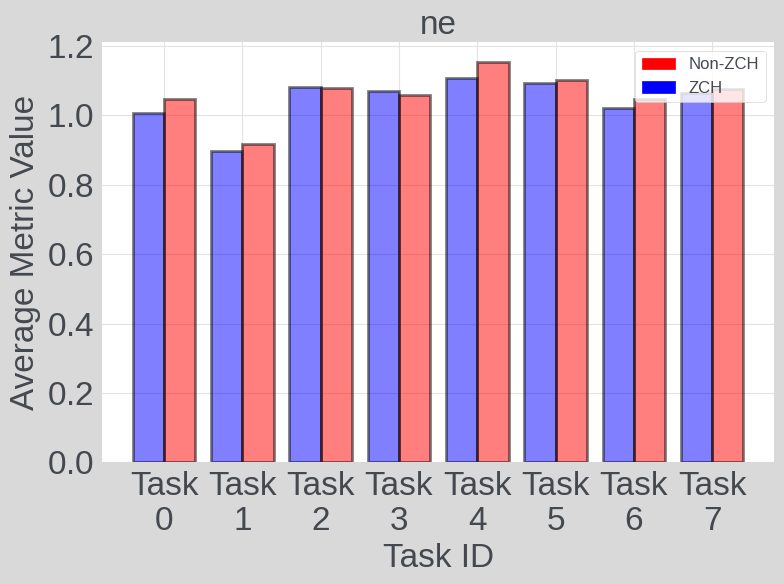

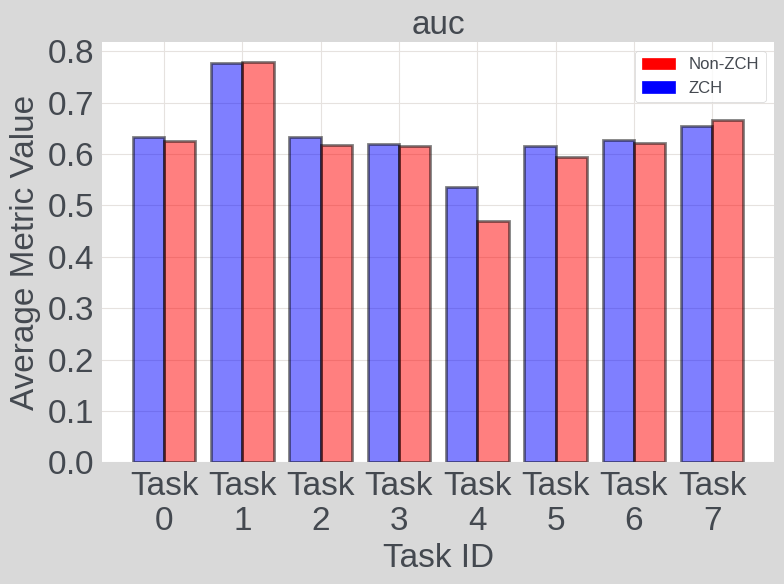

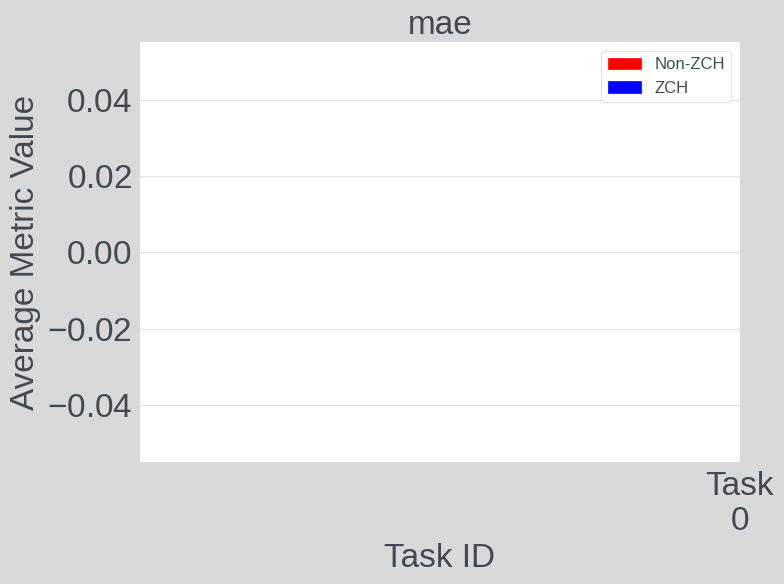

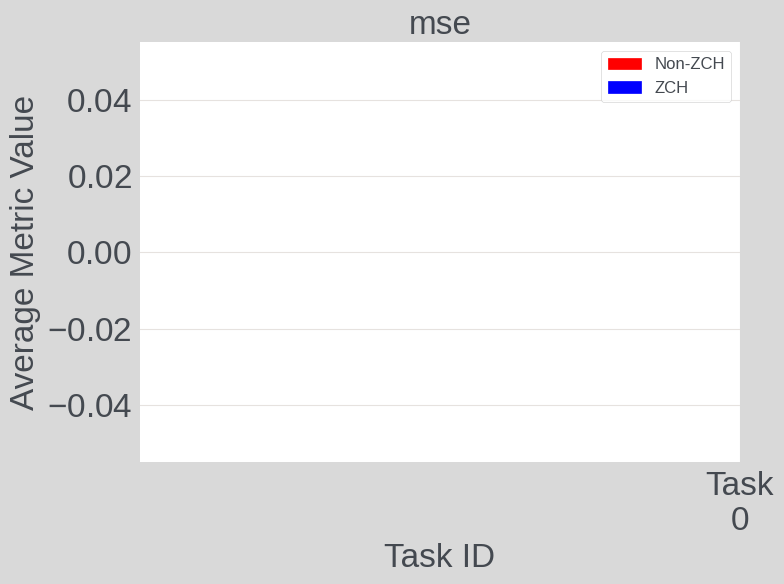

In [8]:
# For each metric, plot a bar chart where each bucket is for a task,
# and in each bucket, every table_size-zch_method combination has a bar
# the Y-axis shows the average metric value of that setting
for metric_name in metrics_task_id_table_size_zch_method_avetage_value_dict:
    fig = plt.figure(figsize=(8, 6))
    font_size = 24
    bucket_width = 0.8
    x_ticks = []
    x_labels = []
    for task_id in metrics_task_id_table_size_zch_method_avetage_value_dict[metric_name]:
        task_bucket_offest = task_id + 1.0
        bucket_bar_label_list = []
        bucket_bar_val_list = []
        bucket_bar_color_list = []
        bucket_bar_shadow_list = []
        for table_size in metrics_task_id_table_size_zch_method_avetage_value_dict[metric_name][task_id]:
            for zch_method in metrics_task_id_table_size_zch_method_avetage_value_dict[metric_name][task_id][table_size]:
                metric_value = metrics_task_id_table_size_zch_method_avetage_value_dict[metric_name][task_id][table_size][zch_method]
                bucket_bar_val_list.append(metric_value)
                bucket_bar_label_list.append(f"{table_size}M-{zch_method}")
                if "nonzch" in zch_method:
                    bucket_bar_color_list.append("red")
                    bucket_bar_shadow_list.append((0, 0))
                else:
                    bucket_bar_color_list.append("blue")
                    bucket_bar_shadow_list.append((1, 1))
        bucket_x_step = bucket_width / len(bucket_bar_label_list)
        bucket_x_offset = bucket_x_step / 2
        plt.bar([x * bucket_x_step + task_bucket_offest - bucket_x_offset for x in range(len(bucket_bar_label_list))] , bucket_bar_val_list, width=bucket_x_step, label=bucket_bar_label_list, color=bucket_bar_color_list, alpha=0.5, edgecolor="black", linewidth=2)
        x_ticks.append(task_bucket_offest)
        x_labels.append(f"Task\n{task_id}")
    # maually set legend to show non-zch is a red bar and zch is a blue bar\
    import matplotlib.patches as mpatches
    # Create custom legend patches
    nonzch_patch = mpatches.Patch(color='red', label='Non-ZCH')
    zch_patch = mpatches.Patch(color='blue', label='ZCH')
    # Add legend to the figure
    plt.legend(handles=[nonzch_patch, zch_patch], loc='upper right')
    # plt.legend()
    plt.xticks(x_ticks, x_labels, fontsize=font_size)
    plt.yticks(fontsize=font_size)
    # plt.legend(fontsize=font_size)
    plt.title(f"{metric_name}", fontsize=font_size)
    plt.xlabel("Task ID", fontsize=font_size)
    plt.ylabel("Average Metric Value", fontsize=font_size)
    plt.grid(True)
    plt.tight_layout()
    plt.savefig(os.path.join(figure_folder, f"eval_metrics_{metric_name}.png"))
    plt.show()
    plt.close(fig)






# plot the ratio of accumulated_collision_count / accumulated_total_count